# Data Analysis Search Results

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import re
import glob
import time
from collections import Counter
import json
from multiprocessing import Pool

from tqdm import tqdm
from lxml import html
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
import seaborn as sns
import numpy as np
from sklearn.utils import resample

from utils import value_counts, calculate_table

In [3]:
# inputs
data_dir = '../data/output/datasets/'
fn_search = f'{data_dir}/searches_check.csv.xz'
fn_products = f'{data_dir}/products.csv.xz'
fn_queries = '../data/input/combined_queries_with_source.csv'
fn_amazon = f'{data_dir}/amazon_private_label.csv.xz'

# intermediary
fn_compare = f'{data_dir}/quality_and_sales_comparisons.csv'

# outputs
output_dir = '../data/output'
table1 = f'{output_dir}/tables/table1-not_always_labelled.csv'
fig2 = f'{output_dir}/figures/fig2-scatter.png'
fig2_csv = f'{output_dir}/figures/fig2-scatter.csv'
fig3a = f'{output_dir}/figures/fig3a-heatmap_amzn.png'
fig3b = f'{output_dir}/figures/fig3b-heatmap-unaffilated.png'
fig3c = f'{output_dir}/figures/fig3c-heatmap-sponsored.png'
fig3a_csv = f'{output_dir}/figures/fig3a-heatmap_amzn.csv'
fig3b_csv = f'{output_dir}/figures/fig3b-heatmap-unaffilated.csv'
fig3c_csv = f'{output_dir}/figures/fig3c-heatmap-sponsored.csv'
table3 = f'{output_dir}/tables/table3-appendix-generic.csv'
for subdir in ['figures', 'tables']:
    os.makedirs(f'{output_dir}/{subdir}', exist_ok=True)

In [5]:
df_amazon = pd.read_csv(fn_amazon, compression='xz')
df_products = pd.read_csv(fn_products, compression='xz')
df_search = pd.read_csv(fn_search, compression='xz')
keywords = pd.read_csv(fn_queries)

In [6]:
keywords.source.value_counts()

autocomplete amazon     7696
autocomplete walmart    3806
seller                  2700
generic                 1600
Name: source, dtype: int64

In [7]:
amazon_asin = set(df_amazon.asin.tolist())
len(amazon_asin)

137428

## merge data

In [8]:
_df_search = df_search[df_search.product_type.isin(['regular_placement'])]

searches_with_amazon_brands = _df_search[
    _df_search.asin.isin(amazon_asin)
].search_term.unique()
len(searches_with_amazon_brands)

4567

In [9]:
_df_search = _df_search[_df_search.search_term.isin(searches_with_amazon_brands)].merge(df_products, how='left')
_df_search['is_amazon'] = _df_search.asin.isin(amazon_asin)

In [10]:
_df_search.iloc[0]

asin                                                              B086VR2KY8
product_name               All-New Toshiba 50LF621U21 50-inch Smart 4K UH...
stars                                                                    4.6
reviews                                                                 5282
brand                                                                    NaN
product_url                /gp/slredirect/picassoRedirect.html/ref=pa_sp_...
is_prime                                                                True
is_fresh                                                               False
is_sponsored                                                           False
is_featured_brand                                                       True
is_amazons_choice                                                      False
is_best_seller                                                         False
has_sponsored_metadata                                                  True

In [11]:
_df_search["is_shipped_by_amazon_TRUE"] = _df_search.apply(lambda x: any([x['is_shipped_by_amazon'], 
                                x['is_fresh'], x['is_prime']]), axis=1)

In [12]:
kw_generic = keywords[keywords['source'] == 'generic'].search_term
kw_seller = keywords[keywords['source'] == 'seller'].search_term
kw_autocomplete = keywords[keywords['source'].isin(
    ['autocomplete amazon', 'autocomplete walmart']
)].search_term

In [13]:
top_searches = set(kw_autocomplete.tolist() + kw_seller.tolist())
len(top_searches)

11342

In [14]:
df_top = _df_search[
    _df_search.search_term.isin(top_searches)
]
len(df_top), df_top.search_term.nunique()

(187534, 3492)

In [15]:
# how many searches had Amazon?
df_top.search_term.nunique() / len(top_searches)

0.30788220772350555

In [16]:
# how many products?
df_top.asin.nunique()

125769

In [39]:
# this is our main dataset
df = df_top
df.search_term.nunique()

3492

In [18]:
# this is the supplementary dataset
df_generic = _df_search[
   _df_search.search_term.isin(kw_generic)
]
len(df_generic), df_generic.search_term.nunique()

(69287, 1217)

In [29]:
df = df[~(df.is_sponsored.isnull()) & 
   ~(df.is_sold_by_amazon.isnull()) &
   ~(df.is_amazon.isnull())]

In [40]:
len(df)

187534

In [49]:
organic= df[df.is_sponsored != True]

In [50]:
vals = {
    'all results': len(df),
    'sponsored' : len(df[df.is_sponsored == True]),
    'organic': len(organic),
    'sold by third party': len(organic[organic.is_sold_by_amazon != True]),
    'sold by amazon': len( organic[organic.is_sold_by_amazon == True] ),
    'amazon brand': len(organic[organic.asin.isin(amazon_asin)]),
    'competing brand' : len(organic[~organic.asin.isin(amazon_asin)])
}

## Produce plots

Our analysis centered around comparing these two metrics:

\begin{align}
{\# 1\ spot}_{Amazon} = \frac{N_{Amazon\ \#1\ slots}}{N_{\#1\ slots}}
\end{align}

\begin{align}
products_{Amazon} = \frac{N_{Amazon\ product\ slots}}{N_{product\ slots}}
\end{align}

In [19]:
res = calculate_table(df, amazon_asin)
res

,Category,Perc Products,Perc #1 spot,Perc first row
0,Unaffiliated,5.808547,4.209622,13.917526
1,Amazon brands,5.801081,19.530355,24.770905
2,Competing brands,76.880992,20.819015,63.516609
3,Sponsored,17.317926,59.650630,75.286369
4,Amazon sold,27.093220,22.451317,47.079038
5,Third-party sold,55.588853,17.898053,48.224513
6,Amazon shipped,76.890591,38.459336,72.565865
7,Third-party shipped,5.791483,1.890034,8.161512


In [20]:
cat2color = {
    'Amazon brands' : "#ff9900",
    'Competing brands' : "#146eb4",
    'Sponsored': '#DB4437',
    'Organic': '#ee7e6c',
    'Amazon sold': '#146eb4',
    'Third-party sold': '#aabedf',
    'Unaffiliated': 'black',
}

mkr_dict = {
    'Unaffiliated': {
        'marker' : 'v',
        'color': ''
    },
    'Competing brands': {
        'marker' : 'o',
        'color' : ''
    }, 
    'Amazon sold' : {
        'marker': '+',
        'color' : ''
    },
    'Third-party sold': {
        'marker': '+',
        'color' : ''
    },
    'Amazon brands': {
        'marker': 'o',
        'color' : ''
    },
    'Sponsored' : {
        'marker' : '*',
        'color' : ''
    },
}

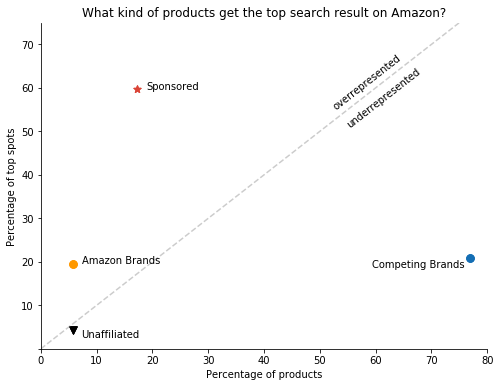

In [21]:
cats = [
    'Sponsored',
    'Amazon brands', 
    'Competing brands',
    'Unaffiliated'
]
plt.figure(figsize=(8, 6))
plt.title("What kind of products get the top search result on Amazon?")
ax = plt.gca()

to_plot = res[res.Category.isin(cats)]
to_plot.to_csv(fig2_csv)

# Hide the right and top spines
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

# Only show ticks on the left and bottom spines
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')

ax.set_ylabel('Percentage of top spots')
ax.set_xlabel('Percentage of products')

ax.set_ylim(0, 75)
ax.set_xlim(0, 80) 
ax.yaxis.get_major_ticks()[0].label1.set_visible(False)

for kind in cats:
    d = to_plot[to_plot.Category==kind]
    if kind in ['Unaffiliated']:
        ax.annotate(kind.title(), (d['Perc Products'] + 1.5,
                       d['Perc #1 spot'] - 1.5))
    elif kind == 'Competing brands':
        ax.annotate(kind.title(), (d['Perc Products'] - 17.5,
                       d['Perc #1 spot'] - 2))
    else:
        ax.annotate(kind.title(), (d['Perc Products'] + 1.6,
                           d['Perc #1 spot']))
    for j in range(1,6):
        plt.scatter(x=d['Perc Products'],
                    y=d['Perc #1 spot'],
                    c=cat2color[kind],
                    s=55,
                    alpha=.2 * j,
                    label=kind,
                    marker = mkr_dict[kind]['marker'])

            
ax.plot([0, 100], [0, 100],  '--', alpha=.4, color='grey')
ax.annotate("overrepresented", 
            (52, 55), rotation=38)
ax.annotate("underrepresented", 
            (54.5, 51), rotation=38)

plt.savefig(fig2);

## Heatmap

In [22]:
def heatmap(df, control, cmap, title, vmin=0, vmax=100, fn_out=None):
    """Produces a heatmap of product slots"""
    amzn_label = (df
        .product_order.value_counts()
        .sort_index()
        .reindex(pd.RangeIndex(1, 61))[::-1])
    amzn_label = amzn_label / control * 100
    if fn_out:
        amzn_label.to_csv(fn_out)
        
    amzn_label_grid = amzn_label.iloc[::-1].values.reshape(15, 4)
    amzn_label_grid = pd.DataFrame(amzn_label_grid)
    amzn_label_grid.index = [_ + 1 for _ in amzn_label_grid.index]
    amzn_label_grid.columns = [_ + 1 for _ in amzn_label_grid.columns]

    fig = plt.figure(figsize=(6,12))
    sns.heatmap(amzn_label_grid,
                linewidths=4,
                fmt='g',
                cmap=cmap,
                vmin=vmax,
                vmax=vmin)
    plt.title(title)
    plt.ylabel("⟵ Rows of products going down the page")
    plt.xlabel("Columns of products across the page")
    plt.yticks(rotation=0)
    
    return fig

In [23]:
n_samples = df.search_term.nunique()

In [24]:
df_s = df[df.is_sponsored == True]
df_ns = df[df.is_sponsored == False]

df_non_amazon = df_ns[(~df_ns.asin.isin(amazon_asin))]
df_amazon_brand_ = df_ns[df_ns.asin.isin(amazon_asin)]


df_non_amazon_ = df_ns[
    (~df_ns.asin.isin(amazon_asin))
  & (df_ns.is_sold_by_amazon != True)
  & (df_ns.is_shipped_by_amazon != True)
  & (df_ns.is_prime != True) 
  & (df_ns.is_fresh != True)
]

In [25]:
control = (df.product_order.value_counts()
    .sort_index()
    .reindex(pd.RangeIndex(1, 61))[::-1])

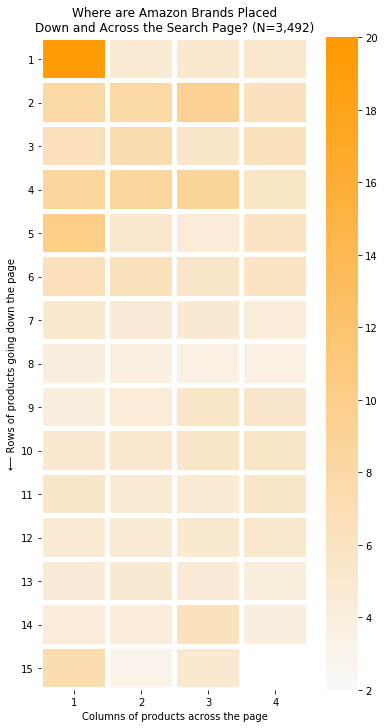

In [26]:
cmap = LinearSegmentedColormap.from_list(
    'mycmap', ['#f9f9f9', "#ff9900"]
)
fig = heatmap(
    df_amazon_brand_, control,
    cmap = LinearSegmentedColormap.from_list(None, ['#f9f9f9', "#ff9900"]),
    title=f"Where are Amazon Brands Placed\nDown and Across the Search Page? (N={n_samples:,})",
    vmax=20, vmin=2, fn_out=fig3a_csv
)
fig.savefig(fig3a);

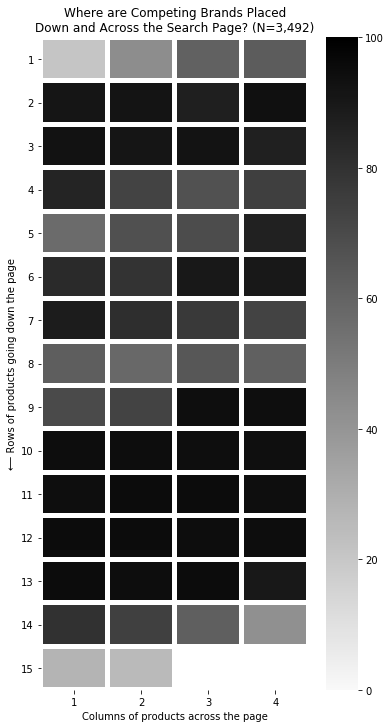

In [27]:
fig = heatmap(
    df_non_amazon, control,
    cmap = LinearSegmentedColormap.from_list(None, ['#f9f9f9', 'black']),
    title=f"Where are Competing Brands Placed\nDown and Across the Search Page? (N={n_samples:,})",
)

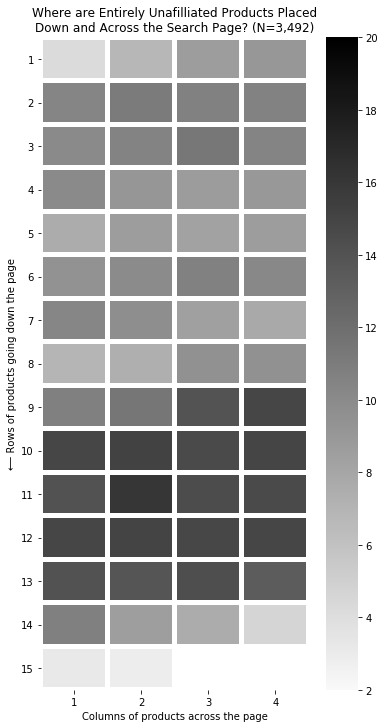

In [28]:
fig = heatmap(
    df_non_amazon_, control,
    cmap = LinearSegmentedColormap.from_list(None, ['#f9f9f9', 'black']),
    title=f"Where are Entirely Unafilliated Products Placed\nDown and Across the Search Page? (N={n_samples:,})",
    vmin=2, vmax=20, fn_out=fig3b_csv
)
fig.savefig(fig3b)

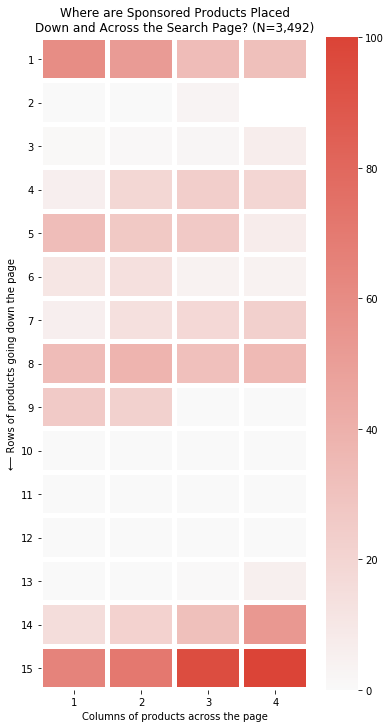

In [29]:
fig = heatmap(
    df_s, control, 
    cmap=LinearSegmentedColormap.from_list(None, ['#f9f9f9', '#DB4437']),
    title=f"Where are Sponsored Products Placed\nDown and Across the Search Page? (N={n_samples:,})",
    fn_out=fig3c_csv
)
fig.savefig(fig3c)

## Not Clearly Labelled

In [30]:
amazon_missed_all = '|'.join([
    'amazon basics',
    'amazonbasics',
    'amazon essentials',
    'whole foods market',
    'amazon commercial',
    'amazon collection',
    'amazon fresh',
    'amazon elements',
    '365 everyday value',
    'amazon exclusive',
    'amazon us exclusive',
    'amazon brand'
])

amazon_missed = '|'.join([
    'amazon basics',
    'amazon essentials',
    'whole foods market',
    'amazon commercial',
    'amazon collection',
    'amazon fresh',
    'amazon elements',
    'amazonbasics',
    '365 everyday value',
])

amazon_disclaimer = '|'.join([
    'amazon exclusive',
    'amazon us exclusive',
    'amazon brand'
])

In [31]:
# How many products contain a disclaimer
disclaimer = (df[
  ((df.is_featured_brand) | 
   (df.product_name.str.contains(amazon_disclaimer, case=False))) &
  (df.asin.isin(amazon_asin))
].asin.nunique() / 
df[df.asin.isin(amazon_asin)].asin.nunique())

disclaimer

0.4204641707606302

In [32]:
# how many items contain a name with known brand
known_brand = (df[
  (df.product_name.str.contains(amazon_missed, case=False)) &
  (df.asin.isin(amazon_asin))
].asin.nunique() / 
df[df.asin.isin(amazon_asin)].asin.nunique())

known_brand

0.2879891580552262

In [33]:
# How many do not contain a disclaimer or well known brand?
not_labelled = 1 - (df[
  ((df.product_name.str.contains(amazon_missed_all, case=False)) | 
   (df.is_featured_brand)) &
  (df.asin.isin(amazon_asin))
].asin.nunique() / 
df[df.asin.isin(amazon_asin)].asin.nunique())

not_labelled

0.37438590547179396

In [34]:
t1 = pd.DataFrame([
    {"" : "Labelled with a Disclaimer", "percentage": disclaimer * 100},
    {"" : "Well-Known Amazon private label", "percentage": known_brand * 100},
    {"" : "Total Labelled", "percentage": (1-not_labelled) * 100},
    {"" : "Total Unlabelled", "percentage": not_labelled * 100},
])
t1 = t1.round(1)
t1.to_csv(table1, index=False)
t1

,,percentage
0,Labelled with a Disclaimer,42.0
1,Well-Known Amazon private label,28.8
2,Total Labelled,62.6
3,Total Unlabelled,37.4


In [35]:
# perc of top amazon products with a "featured from our brands" tag
(df[
    (df.is_featured_brand) &
    (df.asin.isin(amazon_asin)) &
    (df.product_order == 1)
].search_term.nunique()) / df[(df.asin.isin(amazon_asin)) & (df.product_order == 1)].search_term.nunique()

0.8387978142076503

In [36]:
# perc of top "featured from our brands" products with "sponsored" metadata
(df[
    (df.is_featured_brand) &
    (df.asin.isin(amazon_asin)) &
    (df.product_order == 1) &
    (df.has_sponsored_metadata == True)
].search_term.nunique()) / \
(df[
    (df.is_featured_brand) &
    (df.asin.isin(amazon_asin)) &
    (df.product_order == 1)
].search_term.nunique())

1.0

## More Stars and reviews?

In [37]:
if not os.path.exists(fn_compare):   
    data = []
    for st, _df in tqdm(df[df.is_sponsored == False].groupby("search_term")):
        _df.sort_values(by='product_order')
        amzn = _df[_df.asin.isin(amazon_asin)]
        non_amzn = _df[~_df.asin.isin(amazon_asin)]
        wnon_amzn =_df[
            (~_df.asin.isin(amazon_asin)) &
            (_df.is_sold_by_amazon == False) &
            (_df.is_fresh == False) &
            (_df.is_prime == False)
        ]

        if not amzn.empty:
            top_amazon =  amzn.product_order.iloc[0]
            amazon_star = amzn.stars.iloc[0]
            amazon_review = amzn.reviews.iloc[0]
        else:
            top_amazon = np.nan
            amazon_star = np.nan
            amazon_review = np.nan

        if not non_amzn.empty:    
            top_non_amazon_brand = non_amzn.product_order.iloc[0]
            non_amazon_star = non_amzn.stars.iloc[0]
            non_amazon_review = non_amzn.reviews.iloc[0]
        else:
            top_non_amazon = np.nan
            non_amazon_star = np.nan
            non_amazon_review = np.nan

        if not wnon_amzn.empty:
            top_wnon_amazon = wnon_amzn.product_order.iloc[0]
            wnon_amazon_star = wnon_amzn.stars.iloc[0]
            wnon_amazon_review = wnon_amzn.reviews.iloc[0]

        else:
            top_wnon_amazon = np.nan
            wnon_amazon_star = np.nan
            wnon_amazon_review = np.nan
        record = {
            "search_term": st,
            "position_first_amazon": top_amazon,
            "position_first_non_amazon": top_non_amazon_brand,
            "position_first_wholly_non_amazon": top_wnon_amazon,

            "amazon_stars": amazon_star,
            "amazon_reviews": amazon_review,

            "non_amazon_stars": non_amazon_star,
            "non_amazon_reviews": non_amazon_review,

            "wnon_amazon_stars": wnon_amazon_star,
            "wnon_amazon_reviews": wnon_amazon_review,
        }
        data.append(record)
    df_compare = pd.DataFrame(data)
    df_compare.to_csv(fn_compare, index=False)
    
else:
    df_compare = pd.read_csv(fn_compare)

In [38]:
# how often is Amazon placed before non-Amazon? Should be close to one-in-five
len(df_compare[df_compare.position_first_amazon < df_compare.position_first_non_amazon]) / len(df_compare)

0.22880870561282932

In [39]:
# how many Amazon products have more stars?
df_compare[
    df_compare.position_first_amazon < df_compare.position_first_non_amazon
].apply(
    lambda x:
    x['amazon_stars'] > x['non_amazon_stars'],
    axis=1
).value_counts(normalize=True)

False    0.653317
True     0.346683
dtype: float64

In [40]:
# how many Amazon products have more reivews?
df_compare[
    (df_compare.position_first_amazon < df_compare.position_first_non_amazon) &
    (~df_compare.non_amazon_reviews.isnull())
].apply(
    lambda x:
    x['amazon_reviews'] > x['non_amazon_reviews'],
    axis=1
).value_counts(normalize=True)

False    0.517241
True     0.482759
dtype: float64

In [41]:
# how many Amazon products have more reivews and stars?
df_compare[
    (df_compare.position_first_amazon < df_compare.position_first_non_amazon) &
    (~df_compare.non_amazon_reviews.isnull())
].apply(
    lambda x:
    (x['amazon_reviews'] < x['non_amazon_reviews']) and 
    (x['amazon_stars'] < x['non_amazon_stars']),
    axis=1
).value_counts(normalize=True)

False    0.720307
True     0.279693
dtype: float64

In [42]:
# duplicates
asins_by_search = df[df.is_sponsored == False].groupby('search_term').asin.value_counts()

In [43]:
# perc_searches_dupluicate_asin
asins_by_search[asins_by_search > 1].index.get_level_values(0).nunique() / df.search_term.nunique()

0.09221076746849943

In [44]:
# how many of these duplicates are Amazon products?
duplicate_asin = asins_by_search[asins_by_search > 1].index.get_level_values(1)
len([_ for _ in duplicate_asin if _ in amazon_asin]) / len(duplicate_asin)

1.0

## Supplementary dataset

In [45]:
df_generic.search_term.nunique()

1217

In [46]:
table_generic = calculate_table(df_generic, amazon_asin)
table_generic

,Category,Perc Products,Perc #1 spot,Perc first row
0,Unaffiliated,2.987573,1.479047,7.723911
1,Amazon brands,8.225208,24.897288,35.332786
2,Competing brands,73.530388,10.764174,54.478225
3,Sponsored,18.244404,64.338537,84.223500
4,Amazon sold,26.494148,23.336072,46.507806
5,Third-party sold,55.261449,12.325390,46.918652
6,Amazon shipped,78.762250,34.921939,70.172555
7,Third-party shipped,2.993347,0.739523,3.779786


In [47]:
table_top = calculate_table(df_top, amazon_asin)
table_top

,Category,Perc Products,Perc #1 spot,Perc first row
0,Unaffiliated,5.808547,4.209622,13.917526
1,Amazon brands,5.801081,19.530355,24.770905
2,Competing brands,76.880992,20.819015,63.516609
3,Sponsored,17.317926,59.650630,75.286369
4,Amazon sold,27.093220,22.451317,47.079038
5,Third-party sold,55.588853,17.898053,48.224513
6,Amazon shipped,76.890591,38.459336,72.565865
7,Third-party shipped,5.791483,1.890034,8.161512


In [48]:
df[df.is_amazon == True].asin.nunique() / df[(df.product_order == 1) & (df.is_amazon == True)].search_term.nunique()

8.064207650273223

In [49]:
df[df.is_amazon != True].asin.nunique() / df[(df.product_order == 1) & (df.is_amazon != True)].search_term.nunique()

43.42971014492753

In [50]:
df[(df.product_order == 1) & (df.is_amazon == True)].search_term.nunique()

732

In [51]:
table_diff = table_generic.set_index('Category').subtract(
    table_top.set_index('Category'))

In [52]:
comparison = pd.concat([
    table_top[['Category', 'Perc Products',  'Perc #1 spot']].set_index('Category'), 
    table_generic[['Category','Perc Products',  'Perc #1 spot']].set_index('Category'),
], axis=1, keys=["top", "generic"])

In [53]:
comparison

top                    generic             
                    Perc Products Perc #1 spot Perc Products Perc #1 spot
Category                                                                 
Unaffiliated             5.808547     4.209622      2.987573     1.479047
Amazon brands            5.801081    19.530355      8.225208    24.897288
Competing brands        76.880992    20.819015     73.530388    10.764174
Sponsored               17.317926    59.650630     18.244404    64.338537
Amazon sold             27.093220    22.451317     26.494148    23.336072
Third-party sold        55.588853    17.898053     55.261449    12.325390
Amazon shipped          76.890591    38.459336     78.762250    34.921939
Third-party shipped      5.791483     1.890034      2.993347     0.739523

In [54]:
# note some manual changes are made to this CSV file before it went into our article.
comparison.round(1).to_csv(table3)

## Anecdotes

In [55]:
# how many Amazon products have more reivews and stars
df_compare["better_stars_and_reviews"] = df_compare.apply(
    lambda x:
    (x['amazon_reviews'] < x['non_amazon_reviews']) and 
    (x['amazon_stars'] < x['non_amazon_stars']),
    axis=1
)

In [56]:
df_compare[
    (df_compare.position_first_amazon < df_compare.position_first_non_amazon) &
    (~df_compare.non_amazon_reviews.isnull()) &
    (df_compare["better_stars_and_reviews"] == True) &
    (df_compare['position_first_amazon'] == 1)
].search_term.to_csv('amazon_winner_searches.csv', index=False)

## How many more Sponsored products would we have if we counted carousels?

In [57]:
df_carousels = df_search[~df_search.product_type.isin(['regular_placement'])]
df_carousels_ = df_carousels[df_carousels.search_term.isin(top_searches)]

In [59]:
df_carousels_.product_type.value_counts()

sponsored_banner             22923
editorial_recs_carousel      22797
featured_brands_carousel      8546
regular_placement__missed     4907
misc_carousel                 1859
misc_sponsored_carousel       1284
Name: product_type, dtype: int64

In [63]:
sponsored_modules = [
    'sponsored_banner',
    'editorial_recs_carousel',
    'misc_carousel',
    'misc_sponsored_carousel'
]

numerator = len(df_top[df_top.is_sponsored == True]) + len(df_carousels_[df_carousels_.product_type.isin(sponsored_modules) ])
denominator = len(df_top) + len(df_carousels_[df_carousels_.product_type != 'regular_placement__missed'])
numerator / denominator

0.31910884411095186